In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName("HeartDataAnalysis").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/06 20:57:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
file1 = "heart.csv"
file2 = "heart2.csv"
df1 = spark.read.csv(file1, header=True, inferSchema=True)
df2 = spark.read.csv(file2, header=True, inferSchema=True)

In [4]:
df1.show()
df1.columns


+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease']

In [5]:
df2.show()
df2.columns


+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
|Age|Sex|Chest pain type| BP|Cholesterol|FBS over 120|EKG results|Max HR|Exercise angina|ST depression|Slope of ST|Number of vessels fluro|Thallium|Heart Disease|
+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
| 70|  1|              4|130|        322|           0|          2|   109|              0|          2.4|          2|                      3|       3|     Presence|
| 67|  0|              3|115|        564|           0|          2|   160|              0|          1.6|          2|                      0|       7|      Absence|
| 57|  1|              2|124|        261|           0|          0|   141|              0|          0.3|          1|                      0|       7|     Presence|
| 64|  1|             

['Age',
 'Sex',
 'Chest pain type',
 'BP',
 'Cholesterol',
 'FBS over 120',
 'EKG results',
 'Max HR',
 'Exercise angina',
 'ST depression',
 'Slope of ST',
 'Number of vessels fluro',
 'Thallium',
 'Heart Disease']

In [6]:
df2 = df2.withColumnRenamed("Chest pain type", "ChestPainType") \
         .withColumnRenamed("BP", "RestingBP") \
         .withColumnRenamed("FBS over 120", "FastingBS") \
         .withColumnRenamed("EKG results", "RestingECG") \
         .withColumnRenamed("Exercise angina", "ExerciseAngina") \
         .withColumnRenamed("Max HR", "MaxHR") \
         .withColumnRenamed("ST depression", "Oldpeak") \
         .withColumnRenamed("Slope of ST", "ST_Slope") \
         .withColumnRenamed("Heart Disease", "HeartDisease")

In [7]:
df1 = df1.withColumn("Sex", F.when(F.col("Sex") == "M", 1).otherwise(0))

df1 = df1.withColumn("ChestPainType", 
                     F.when(F.col("ChestPainType") == "TA", 1)
                     .when(F.col("ChestPainType") == "ATA", 2)
                     .when(F.col("ChestPainType") == "NAP", 3)
                     .otherwise(4))

df1 = df1.withColumn("FastingBS", F.when(F.col("FastingBS") == 1, 1).otherwise(0))

df1 = df1.withColumn("RestingECG", 
                     F.when(F.col("RestingECG") == "Normal", 0)
                     .when(F.col("RestingECG") == "ST", 1)
                     .otherwise(2))

df1 = df1.withColumn("ExerciseAngina", F.when(F.col("ExerciseAngina") == "Y", 1).otherwise(0))

df1 = df1.withColumn("ST_Slope", 
                     F.when(F.col("ST_Slope") == "Up", 1)
                     .when(F.col("ST_Slope") == "Flat", 2)
                     .otherwise(3))

df2 = df2.withColumn("HeartDisease", 
                     F.when(F.col("HeartDisease") == "Absence", 0)
                     .otherwise(1))

In [8]:
columns_to_drop = ["Number of vessels fluro", "Thallium"]
df2 = df2.drop(*columns_to_drop)

In [9]:
df_merged = df1.union(df2)


In [10]:
df_merged.show()
df_merged.printSchema()


+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  1|            2|      140|        289|        0|         0|  172|             0|    0.0|       1|           0|
| 49|  0|            3|      160|        180|        0|         0|  156|             0|    1.0|       2|           1|
| 37|  1|            2|      130|        283|        0|         1|   98|             0|    0.0|       1|           0|
| 48|  0|            4|      138|        214|        0|         0|  108|             1|    1.5|       2|           1|
| 54|  1|            3|      150|        195|        0|         0|  122|             0|    0.0|       1|           0|
| 39|  1|            3|      120|        339|        0| 

In [11]:
df_merged.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- ChestPainType: integer (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: integer (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: integer (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: integer (nullable = true)
 |-- HeartDisease: integer (nullable = true)



In [12]:
df_merged.filter(df_merged["RestingBP"] == 0).count()


1

+-------+------------------+
|summary|       Cholesterol|
+-------+------------------+
|  count|              1188|
|   mean|210.35858585858585|
| stddev|101.50556295703767|
|    min|                 0|
|    max|               603|
+-------+------------------+



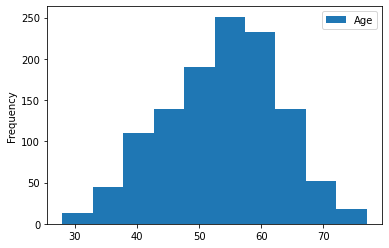

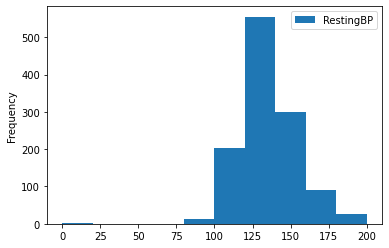

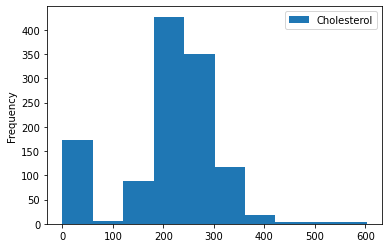

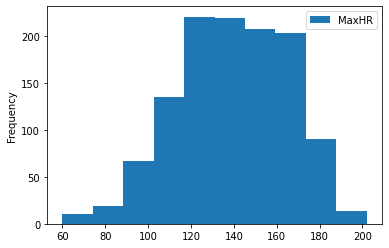

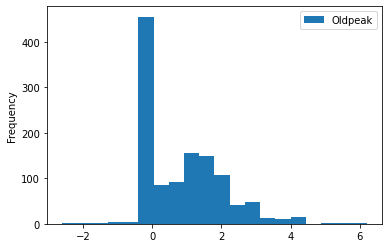

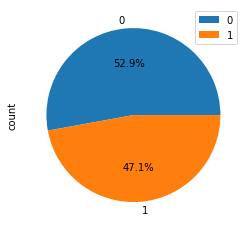

In [13]:
df_merged.select("Age").toPandas().plot.hist()
df_merged.select("RestingBP").toPandas().plot.hist()
df_merged.select("Cholesterol").toPandas().plot.hist()
df_merged.select("MaxHR").toPandas().plot.hist()
df_merged.select("Oldpeak").toPandas().plot.hist(bins=20)
df_merged.groupBy("HeartDisease").count().toPandas().plot.pie(y="count", autopct="%1.1f%%")
df_merged.select("Cholesterol").describe().show()

In [14]:
null_counts = df_merged.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_merged.columns])
null_counts.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



<AxesSubplot:>

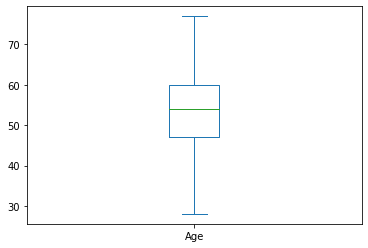

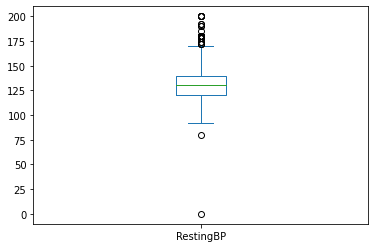

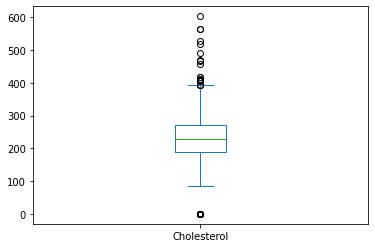

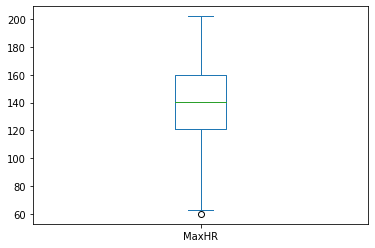

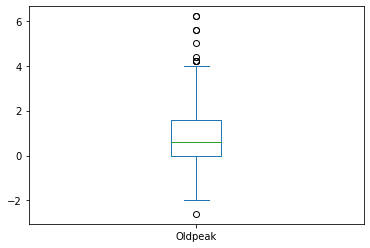

In [15]:
df_merged.select("Age").toPandas().plot.box()
df_merged.select("RestingBP").toPandas().plot.box()
df_merged.select("Cholesterol").toPandas().plot.box()
df_merged.select("MaxHR").toPandas().plot.box()
df_merged.select("Oldpeak").toPandas().plot.box()

In [16]:
df_filtered = df_merged.filter(df_merged['RestingBP'] != 0)
df_filtered.filter(df_merged["RestingBP"] == 0).count()

0

In [17]:
non_zero_cholesterol = df_filtered.filter(df_filtered['Cholesterol'] != 0)
chol_median = non_zero_cholesterol.approxQuantile(col='Cholesterol',probabilities=[0.5,],relativeError=0)
chol_median[0]

240.0

In [18]:
from pyspark.sql.functions import when
df_filtered = df_filtered.withColumn('Cholesterol', when(df_filtered['Cholesterol'] == 0, chol_median[0]).otherwise(df_filtered['Cholesterol']))

<AxesSubplot:ylabel='Frequency'>

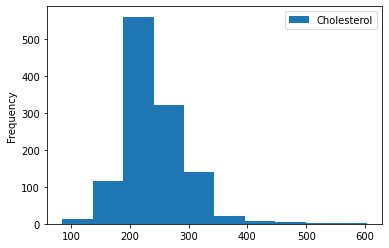

In [19]:
df_filtered.select("Cholesterol").toPandas().plot.hist()

In [20]:
df_filtered = df_filtered.withColumn(
    'BPtype',
    when(col('RestingBP') <= 120, 0)
    .when((col('RestingBP') > 120) & (col('RestingBP') <= 139), 1)
    .otherwise(2)
)
df_filtered = df_filtered.drop('RestingBP')

In [21]:
df_filtered = df_filtered.withColumn('Age_Cholesterol_rate', col('Cholesterol') * col('Age'))

In [22]:
df_filtered.show()

+---+---+-------------+-----------+---------+----------+-----+--------------+-------+--------+------------+------+--------------------+
|Age|Sex|ChestPainType|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|BPtype|Age_Cholesterol_rate|
+---+---+-------------+-----------+---------+----------+-----+--------------+-------+--------+------------+------+--------------------+
| 40|  1|            2|      289.0|        0|         0|  172|             0|    0.0|       1|           0|     2|             11560.0|
| 49|  0|            3|      180.0|        0|         0|  156|             0|    1.0|       2|           1|     2|              8820.0|
| 37|  1|            2|      283.0|        0|         1|   98|             0|    0.0|       1|           0|     1|             10471.0|
| 48|  0|            4|      214.0|        0|         0|  108|             1|    1.5|       2|           1|     1|             10272.0|
| 54|  1|            3|      195.0|        0|   

In [23]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer,VectorSlicer
from pyspark.sql.functions import udf
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.sql.types import ArrayType,FloatType, DoubleType, IntegerType


In [24]:

categorical_columns = ['ChestPainType', 'ST_Slope']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_filtered) for column in categorical_columns]
encoders = [OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[col + "_vec"],dropLast=True) for indexer, col in zip(indexers, categorical_columns)]


In [25]:
print(indexers[1].labels)

['2', '1', '3']


In [26]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + encoders)
df_encoded = pipeline.fit(df_filtered).transform(df_filtered)
selected_cols = [column + "_vec" for column in categorical_columns] + df_filtered.columns
df_encoded = df_encoded.select(selected_cols)

In [27]:
def vector_to_list(v):
    if isinstance(v, SparseVector):
        v = DenseVector(v)
    return v.toArray().tolist()

vector_to_list_udf = udf(vector_to_list, ArrayType(DoubleType()))

In [28]:
for column in ['ChestPainType_vec', 'ST_Slope_vec']:
    df_encoded = df_encoded.withColumn(column+"_list", vector_to_list_udf(col(column)))
    num_categories = len(df_encoded.select(column).first()[0])
    # Extract individual columns from list
    for i in range(num_categories):
        df_encoded = df_encoded.withColumn(column+"_"+str(i), col(column+"_list")[i])

In [29]:
df_encoded.columns

['ChestPainType_vec',
 'ST_Slope_vec',
 'Age',
 'Sex',
 'ChestPainType',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease',
 'BPtype',
 'Age_Cholesterol_rate',
 'ChestPainType_vec_list',
 'ChestPainType_vec_0',
 'ChestPainType_vec_1',
 'ChestPainType_vec_2',
 'ST_Slope_vec_list',
 'ST_Slope_vec_0',
 'ST_Slope_vec_1']

In [30]:
Columns_to_drop2 =["ChestPainType",'ST_Slope','ChestPainType_vec_list', 'ST_Slope_vec_list','ChestPainType_vec','ST_Slope_vec',]
df_encoded=df_encoded.drop(*Columns_to_drop2)


In [31]:
df_encoded.select("ST_Slope_vec_1").show()

+--------------+
|ST_Slope_vec_1|
+--------------+
|           1.0|
|           0.0|
|           1.0|
|           0.0|
|           1.0|
|           1.0|
|           1.0|
|           1.0|
|           0.0|
|           1.0|
|           1.0|
|           0.0|
|           1.0|
|           0.0|
|           1.0|
|           0.0|
|           0.0|
|           1.0|
|           0.0|
|           0.0|
+--------------+
only showing top 20 rows



In [32]:

correlations = {}
for column in df_encoded.columns:
    if column != 'HeartDisease' and isinstance(df_encoded.schema[column].dataType, (FloatType, DoubleType, IntegerType)):
        corr_value = df_encoded.stat.corr(column, 'HeartDisease')
        correlations[column] = corr_value
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
sorted_correlations

[('ChestPainType_vec_0', 0.5166678619757027),
 ('ST_Slope_vec_0', 0.5101184268398316),
 ('ExerciseAngina', 0.48155609793226906),
 ('Oldpeak', 0.3986584915876416),
 ('Sex', 0.30966378262586897),
 ('Age', 0.2614804309278609),
 ('FastingBS', 0.21739936041252822),
 ('Age_Cholesterol_rate', 0.20662252279117013),
 ('BPtype', 0.12170140121918528),
 ('Cholesterol', 0.08626636227703617),
 ('RestingECG', 0.0728399082296723),
 ('ChestPainType_vec_1', -0.23991745322997685),
 ('ChestPainType_vec_2', -0.36181067851086307),
 ('MaxHR', -0.41317265635360617),
 ('ST_Slope_vec_1', -0.5685304729033728)]

In [33]:
columns_drop3 = ['Cholesterol','RestingECG','BPtype']
df3 = df_encoded.drop(*columns_drop3)
df3.columns

['Age',
 'Sex',
 'FastingBS',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'HeartDisease',
 'Age_Cholesterol_rate',
 'ChestPainType_vec_0',
 'ChestPainType_vec_1',
 'ChestPainType_vec_2',
 'ST_Slope_vec_0',
 'ST_Slope_vec_1']

+------------+-----+
|HeartDisease|count|
+------------+-----+
|           1|  627|
|           0|  616|
+------------+-----+



<AxesSubplot:ylabel='count'>

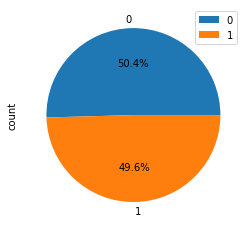

In [34]:
df3_low = df3.filter(col('HeartDisease') == 0)
df3_high = df3.filter(col('HeartDisease') == 1)
num_low = df3_low.count()
num_high = df3_high.count()

df3_low_boosted = df3_low.sample(withReplacement=True, fraction=num_high/num_low)
df3_boosted = df3_high.union(df3_low_boosted)
df3_boosted.groupBy("HeartDisease").count().show()
df4 = df3_boosted

df4.groupBy("HeartDisease").count().toPandas().plot.pie(y="count", autopct="%1.1f%%")

<AxesSubplot:ylabel='Frequency'>

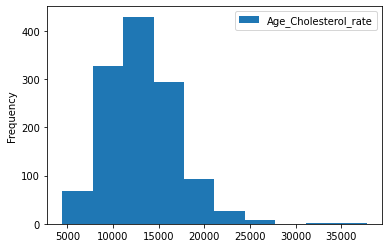

In [35]:
df4.select("Age_Cholesterol_rate").toPandas().plot.hist()

In [36]:
from pyspark.sql.functions import log
df_with_log = df4.withColumn("log_Age_Cholesterol_rate", log(col("Age_Cholesterol_rate")))
df5 = df_with_log

<AxesSubplot:ylabel='Frequency'>

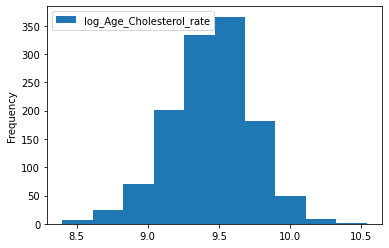

In [37]:
df5.select("log_Age_Cholesterol_rate").toPandas().plot.hist()

In [38]:
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [39]:
feature_columns = [col_name for col_name in df5.columns if col_name != 'HeartDisease']  
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df5)


In [41]:
df_assembled.show()

23/10/06 21:08:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+---+---------+-----+--------------+-------+------------+--------------------+-------------------+-------------------+-------------------+--------------+--------------+------------------------+--------------------+
|Age|Sex|FastingBS|MaxHR|ExerciseAngina|Oldpeak|HeartDisease|Age_Cholesterol_rate|ChestPainType_vec_0|ChestPainType_vec_1|ChestPainType_vec_2|ST_Slope_vec_0|ST_Slope_vec_1|log_Age_Cholesterol_rate|            features|
+---+---+---------+-----+--------------+-------+------------+--------------------+-------------------+-------------------+-------------------+--------------+--------------+------------------------+--------------------+
| 49|  0|        0|  156|             0|    1.0|           1|              8820.0|                0.0|                1.0|                0.0|           1.0|           0.0|       9.084777149000837|(13,[0,3,5,6,8,10...|
| 48|  0|        0|  108|             1|    1.5|           1|             10272.0|                1.0|                0.0|  

In [40]:
(train_data, test_data) = df_assembled.randomSplit([0.7, 0.3])

In [41]:
dt_classifier = DecisionTreeClassifier(labelCol="HeartDisease", featuresCol="features")

dtc_model = dt_classifier.fit(train_data)


23/10/06 08:26:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [42]:
rt_classifier = RandomForestClassifier(labelCol="HeartDisease", featuresCol="features",numTrees=200, maxDepth=30, minInstancesPerNode=2)
rt_model = rt_classifier.fit(train_data)

23/10/06 08:26:19 WARN DAGScheduler: Broadcasting large task binary with size 1571.3 KiB
23/10/06 08:26:20 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/10/06 08:26:21 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/10/06 08:26:22 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/06 08:26:23 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/10/06 08:26:24 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
23/10/06 08:26:25 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/10/06 08:26:26 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/10/06 08:26:27 WARN DAGScheduler: Broadcasting large task binary with size 1721.8 KiB


In [43]:
rt_pre = rt_model.transform(test_data)

In [44]:
evaluator2 = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator2.evaluate(rt_pre)
print(f"Random forest Test Accuracy: {accuracy:.2f}")

23/10/06 08:26:29 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


Random forest Test Accuracy: 0.90


In [45]:
gbt_classifier = GBTClassifier(labelCol="HeartDisease", featuresCol="features")
dc_classifier = DecisionTreeClassifier(labelCol="HeartDisease", featuresCol="features")
gbt_model = gbt_classifier.fit(train_data)
dc_model = dc_classifier.fit(train_data)

In [46]:
gbt_pre = gbt_model.transform(test_data)
dc_pre = dc_model.transform(test_data)

In [47]:
evaluator_gbt = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="accuracy")
accuracy_gbt = evaluator_gbt.evaluate(gbt_pre)
print(f"GBTC Test Accuracy: {accuracy_gbt:.2f}")

23/10/06 08:26:44 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/06 08:26:44 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


GBTC Test Accuracy: 0.87


In [67]:
evaluator_dc = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="accuracy")
accuracy_dc = evaluator_dc.evaluate(dc_pre)
print(f"Decision tree Test Accuracy: {accuracy_dc:.2f}")

Decision tree Test Accuracy: 0.83


In [49]:
from pyspark.mllib.evaluation import MulticlassMetrics
rt_pre = rt_pre.withColumn("prediction", col("prediction").cast("double"))
rt_pre = rt_pre.withColumn("HeartDisease", col("HeartDisease").cast("double"))
prediction_and_label = rt_pre.select("prediction", "HeartDisease").rdd
metrics = MulticlassMetrics(prediction_and_label)
print(metrics.confusionMatrix().toArray())

/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/10/06 08:26:45 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/10/06 08:26:46 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


[[189.  15.]
 [ 27. 186.]]


In [50]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
roc_auc = evaluator2.evaluate(rt_pre)
print(roc_auc)

23/10/06 08:26:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


0.8992805755395683


In [51]:
importances = rt_model.featureImportances

In [52]:
feature_list = feature_columns

In [53]:
importance_list = [importances[i] for i in range(len(feature_list))]

In [54]:
sorted_features = sorted(zip(feature_list, importance_list), key=lambda x: x[1], reverse=True)

In [55]:
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

ST_Slope_vec_1: 0.1575804901263893
ChestPainType_vec_0: 0.11640809475438696
ExerciseAngina: 0.1081423888065742
MaxHR: 0.10118406016102449
Oldpeak: 0.09357860367137895
Age: 0.09338045225089389
ST_Slope_vec_0: 0.09184670473862813
log_Age_Cholesterol_rate: 0.06751542740096388
Age_Cholesterol_rate: 0.06708094311017658
Sex: 0.033788368156514426
ChestPainType_vec_1: 0.030778514969038998
FastingBS: 0.027051173654038977
ChestPainType_vec_2: 0.01166477819999109


In [56]:
features, importances = zip(*sorted_features)

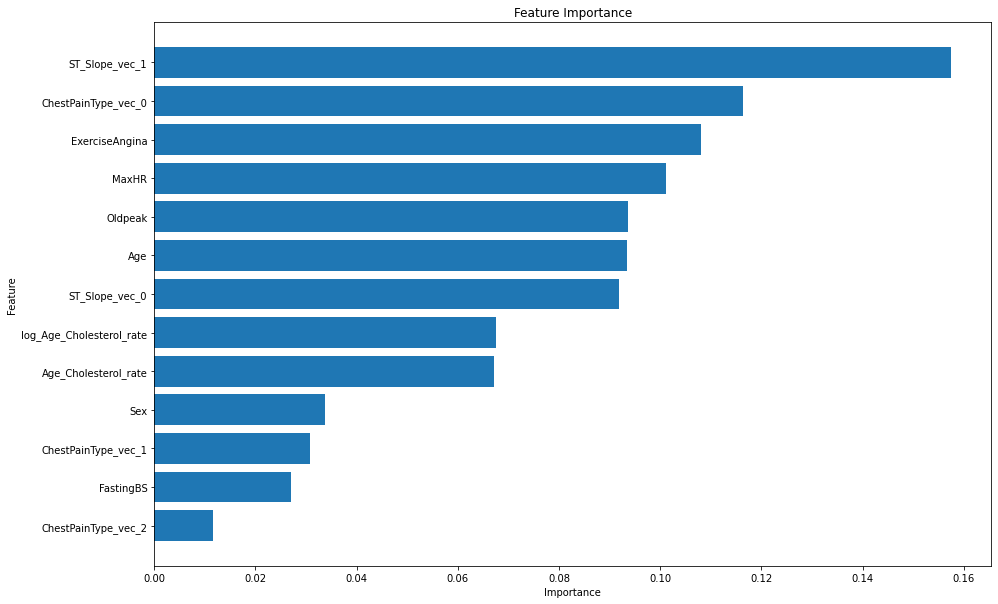

In [57]:
plt.figure(figsize=(15, 10))
plt.barh(features, importances, align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()

In [58]:
from pyspark.sql.functions import when, col, avg
import seaborn as sns

In [63]:
df6 = df5.withColumn(
    "MaxHR_bin", 
    when(col("MaxHR") <= 99, "70-99")
    .when((col("MaxHR") > 99) & (col("MaxHR") <= 129), "100-129")
    .when((col("MaxHR") > 129) & (col("MaxHR") <= 159), "130-159")
    .otherwise("160+")
)
df7 = df5.withColumn(
    "Oldpeak_bin",
    when(col("Oldpeak") <= 0, "0")
    .when((col("Oldpeak") > 0) & (col("Oldpeak") <= 1), "0-1")
    .when((col("Oldpeak") > 1) & (col("Oldpeak") <= 2), "1-2")
    .when((col("Oldpeak") > 2) & (col("Oldpeak") <= 3), "2-3")
    .otherwise("3-6")
)

In [64]:
grouped_data_mhr = df6.groupBy("MaxHR_bin").agg(avg("HeartDisease").alias("avg_HeartDisease"))
grouped_data_old = df7.groupBy("Oldpeak_bin").agg(avg("HeartDisease").alias("avg_HeartDisease"))
grouped_data_st = df5.groupBy("ST_Slope_vec_1").agg(avg("HeartDisease").alias("avg_HeartDisease"))


In [65]:
pdf_mhr = grouped_data_mhr.toPandas()
pdf_old = grouped_data_old.orderBy("Oldpeak_bin").toPandas()
pdf_st = grouped_data_st.toPandas()

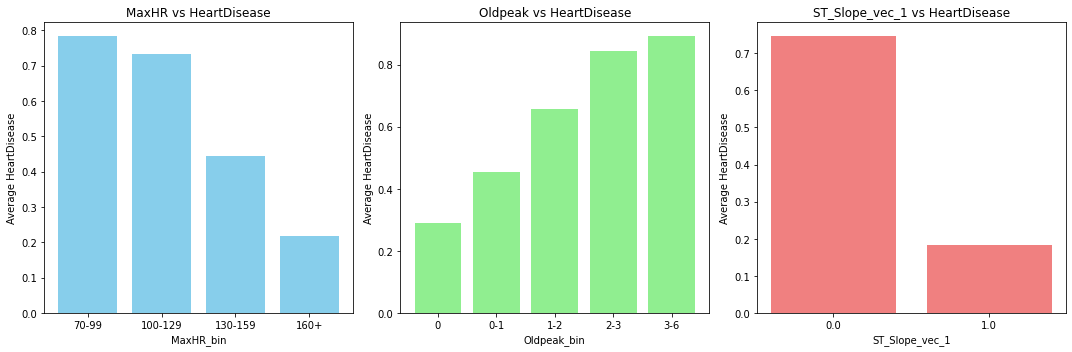

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].bar(pdf_mhr["MaxHR_bin"], pdf_mhr["avg_HeartDisease"], color='skyblue')
axes[0].set_title('MaxHR vs HeartDisease')
axes[0].set_xlabel('MaxHR_bin')
axes[0].set_ylabel('Average HeartDisease')
# Oldpeak vs HeartDisease
axes[1].bar(pdf_old["Oldpeak_bin"], pdf_old["avg_HeartDisease"], color='lightgreen')
axes[1].set_title('Oldpeak vs HeartDisease')
axes[1].set_xlabel('Oldpeak_bin')
axes[1].set_ylabel('Average HeartDisease')
# ST_Slope_vec_1 vs HeartDisease
axes[2].bar(pdf_st["ST_Slope_vec_1"].astype(str), pdf_st["avg_HeartDisease"], color='lightcoral')
axes[2].set_title('ST_Slope_vec_1 vs HeartDisease')
axes[2].set_xlabel('ST_Slope_vec_1')
axes[2].set_ylabel('Average HeartDisease')

plt.tight_layout()
plt.show()